### Import packages

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.ticker import AutoLocator, AutoMinorLocator, LogLocator
import glob
from scipy.interpolate import griddata
from pathlib import Path
import h5py
import sys
from pathlib import Path

# Where am I running?
try:
    # Normal script
    here = Path(__file__).resolve().parent
except NameError:
    # Notebook / REPL
    here = Path.cwd()

phys_const_path = (here / '..' / 'phys_const').resolve()
sys.path.append(str(phys_const_path))

nsm_plots_path = (here / '..' / 'nsm_plots').resolve()
sys.path.append(str(nsm_plots_path))

nsm_plots_postproc = (here / '..' / 'nsm_instabilities').resolve()
sys.path.append(str(nsm_plots_postproc))

import phys_const as pc
import plot_functions as pf
import functions_angular_crossings as fac

### File path

In [156]:
direct = '/home/erick/gw170817_1.00ye_locsim/FFI/cell_15_48_15_d_1_1_20_c_1_1_40'
parfile = '/plt479000_particles'
parfile = '/plt00000_particles'
cellvolume = 0.5 # ccm
finaldir = direct.split('/')[-1]
file = '/allData.h5'
num_particles_per_energy_bin = 378
num_energy_bins = 13
time_s = 0.32/1000 # seconds

print(f'Loading data from {direct}{file}')

Loading data from /home/erick/gw170817_1.00ye_locsim/FFI/cell_15_48_15_d_1_1_20_c_1_1_40/allData.h5


### Define cell index to be analyzed

In [157]:
cell_index_i = 0
cell_index_j = 0
cell_index_k = 0

### Cell to be analized

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of cells: 40
shape of cell_indices: (40, 3)


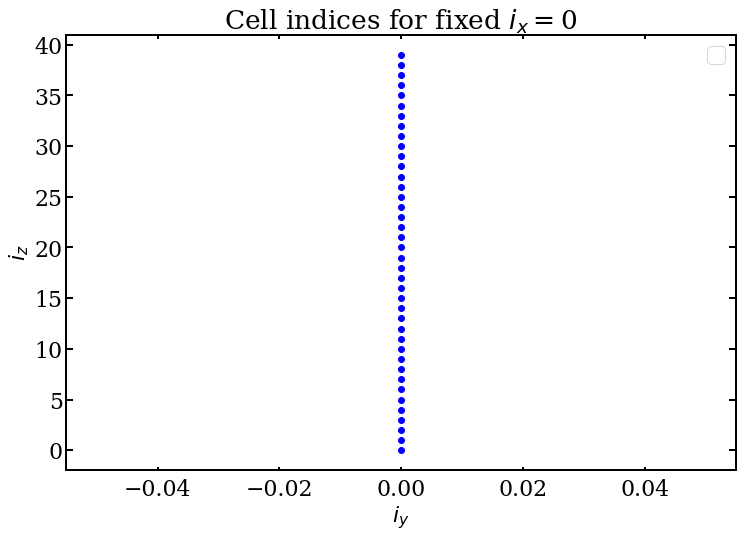

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


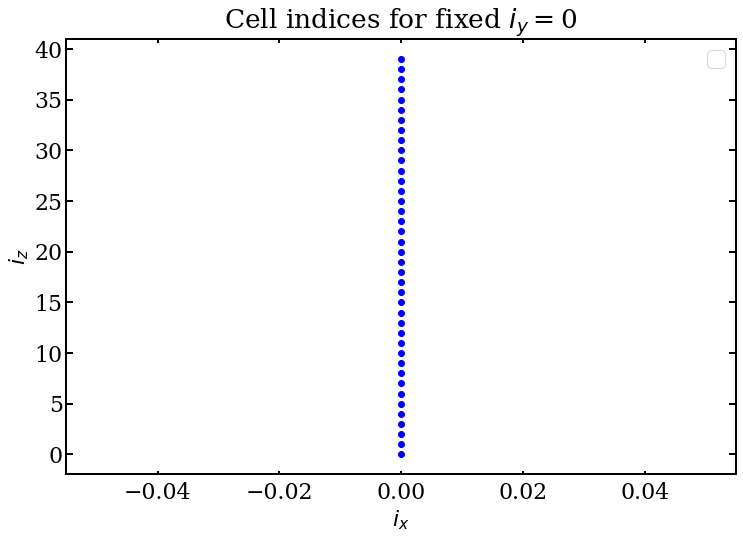

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


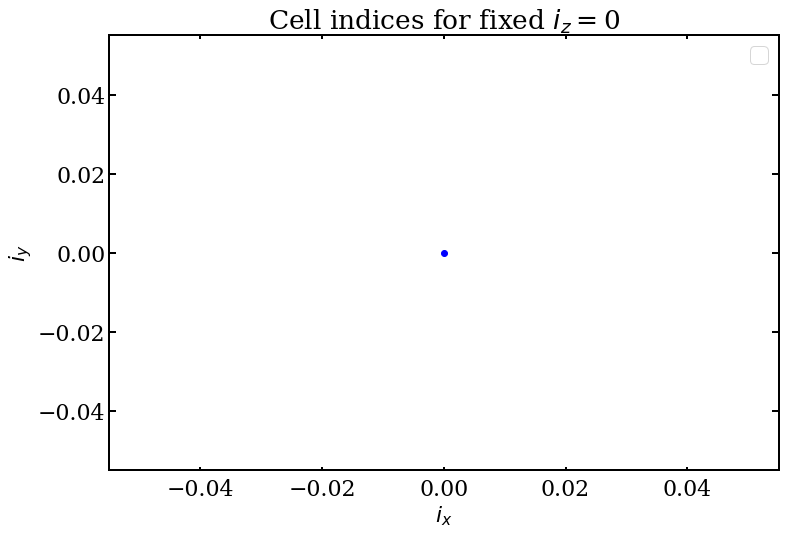

In [158]:
# Get the cell indices
cell_file_names = glob.glob(direct + parfile + '/cell_*_*_*')
cell_file_names = [file_name.split('/')[-1] for file_name in cell_file_names]
x_cell_ind = np.array([int(file_name.split('_')[1]) for file_name in cell_file_names])
y_cell_ind = np.array([int(file_name.split('_')[2]) for file_name in cell_file_names])
z_cell_ind = np.array([int((file_name.split('_')[3]).split('.')[0]) for file_name in cell_file_names])
cell_indices = np.array(list(zip(x_cell_ind, y_cell_ind, z_cell_ind)))
print('Number of cells:', len(cell_indices))
print(f'shape of cell_indices: {cell_indices.shape}')

# Get the cell indices for ix fix but iy and iz varying all available cells
x_idx_slice = cell_index_i
mask_yz_slice = cell_indices[:,0] == x_idx_slice # fixing the x index in this value
cell_indices_yz_slice = cell_indices[mask_yz_slice]
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_yz_slice[:,1], cell_indices_yz_slice[:,2], color='b')
ax.set_xlabel('$i_y$')
ax.set_ylabel('$i_z$')
ax.set_title(f'Cell indices for fixed $i_x=${x_idx_slice}')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

# Get the cell indices for iy fix but ix and iz varying all available cells
y_idx_slice = cell_index_j
mask_xz_slice = cell_indices[:,1] == y_idx_slice # fixing the y index in this value
cell_indices_xz_slice = cell_indices[mask_xz_slice]
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_xz_slice[:,0], cell_indices_xz_slice[:,2], color='b')
ax.set_xlabel('$i_x$')
ax.set_ylabel('$i_z$')
ax.set_title(f'Cell indices for fixed $i_y=${y_idx_slice}')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

# Get the cell indices for iz fix but ix and iy varying all available cells
z_idx_slice = cell_index_k
mask_xy_slice = cell_indices[:,2] == z_idx_slice # fixing the z index in this value
cell_indices_xy_slice = cell_indices[mask_xy_slice]
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(cell_indices_xy_slice[:,0], cell_indices_xy_slice[:,1], color='b')
ax.set_xlabel('$i_x$')
ax.set_ylabel('$i_y$')
ax.set_title(f'Cell indices for fixed $i_z=${z_idx_slice}')
ax.legend()
# ax.set_xlim([-5,100])
# ax.set_ylim([-5,70])
plt.show()
plt.close(fig)

# Combine all cell indices from the three slices
# cell_indices_all = np.concatenate((cell_indices_yz_slice, cell_indices_xz_slice, cell_indices_xy_slice), axis=0)
cell_indices_all = np.concatenate((cell_indices_xz_slice, cell_indices_xy_slice), axis=0)
cell_indices_all = np.unique(cell_indices_all, axis=0)

### Compute ELN number density

In [159]:
# Dictionary keys
# <KeysViewHDF5 ['N00_Re', 'N00_Rebar', 'N01_Im', 'N01_Imbar', 'N01_Re', 'N01_Rebar', 'N02_Im', 'N02_Imbar', 'N02_Re', 'N02_Rebar', 'N11_Re', 'N11_Rebar', 'N12_Im', 'N12_Imbar', 'N12_Re', 'N12_Rebar', 'N22_Re', 'N22_Rebar', 'TrHN', 'Vphase', 'pos_x', 'pos_y', 'pos_z', 'pupt', 'pupx', 'pupy', 'pupz', 'time', 'x', 'y', 'z']>

particles_dict_this_cell = fac.load_particle_data(cell_index_i, cell_index_j, cell_index_k, direct + parfile)

px = particles_dict_this_cell['pupx']/particles_dict_this_cell['pupt']
py = particles_dict_this_cell['pupy']/particles_dict_this_cell['pupt']
pz = particles_dict_this_cell['pupz']/particles_dict_this_cell['pupt']
print(f'pz.shape = {pz.shape}')

momentum = np.stack((px, py, pz), axis=-1)
tolerance = 1.0e-4
unique_momentum = fac.get_unique_momentum(momentum, tolerance)
print(f'unique_momentum.shape = {unique_momentum.shape}')

theta = np.arccos(unique_momentum[:,2])
phi = np.arctan2(unique_momentum[:,1], unique_momentum[:,0])
phi = np.where(phi < 0, phi + 2 * np.pi, phi) # Adjusting the angle to be between 0 and 2pi.

nee_all     = particles_dict_this_cell['N00_Re']    / cellvolume
nuu_all     = particles_dict_this_cell['N11_Re']    / cellvolume
ntt_all     = particles_dict_this_cell['N22_Re']    / cellvolume
neebar_all  = particles_dict_this_cell['N00_Rebar'] / cellvolume
nuubar_all  = particles_dict_this_cell['N11_Rebar'] / cellvolume
nttbar_all = particles_dict_this_cell['N22_Rebar']  / cellvolume

fluxee_all    = nee_all   [:, np.newaxis] * momentum
fluxuu_all    = nuu_all   [:, np.newaxis] * momentum
fluxtt_all    = ntt_all   [:, np.newaxis] * momentum
fluxeebar_all = neebar_all[:, np.newaxis] * momentum
fluxuubar_all = nuubar_all[:, np.newaxis] * momentum
fluxnttbar_all = nttbar_all[:, np.newaxis] * momentum

ee_unique_fluxes, ee_unique_fluxes_mag       = fac.compute_unique_fluxes(momentum, fluxee_all, unique_momentum)
uu_unique_fluxes, uu_unique_fluxes_mag       = fac.compute_unique_fluxes(momentum, fluxuu_all, unique_momentum)
tt_unique_fluxes, tt_unique_fluxes_mag       = fac.compute_unique_fluxes(momentum, fluxtt_all, unique_momentum)
eebar_unique_fluxes, eebar_unique_fluxes_mag = fac.compute_unique_fluxes(momentum, fluxeebar_all, unique_momentum)
uubar_unique_fluxes, uubar_unique_fluxes_mag = fac.compute_unique_fluxes(momentum, fluxuubar_all, unique_momentum)
ttbar_unique_fluxes, ttbar_unique_fluxes_mag = fac.compute_unique_fluxes(momentum, fluxnttbar_all, unique_momentum)

eln_xln = (
    (ee_unique_fluxes_mag - eebar_unique_fluxes_mag ) -
    (uu_unique_fluxes_mag - uubar_unique_fluxes_mag ) -  
    (tt_unique_fluxes_mag - ttbar_unique_fluxes_mag ) 
)

Loading data from /home/erick/gw170817_1.00ye_locsim/FFI/cell_15_48_15_d_1_1_20_c_1_1_40/plt00000_particles/cell_0_0_0.h5
pz.shape = (4914,)
unique_momentum.shape = (378, 3)


### Estimate FFI growth rate base on Box3D prediction

In [160]:
sigma = 0.0
GnPos = 0.0
GnNeg = 0.0

G_ELN = np.sqrt(2) * pc.PhysConst.GF * ( pc.PhysConst.hbarc**3 / pc.PhysConst.hbar ) * eln_xln

mask_pos_eln = G_ELN > 0
mask_neg_eln = G_ELN < 0

print(f'Number of positive G_ELN: {np.sum(mask_pos_eln)}')
print(f'Number of negative G_ELN: {np.sum(mask_neg_eln)}\n')

sum_pos_eln = np.sum(G_ELN[mask_pos_eln])
sum_neg_eln = -1.0*np.sum(G_ELN[mask_neg_eln])

GnPos = sum_pos_eln
GnNeg = sum_neg_eln

print('Sum of positive G_ELN: {:.3e} 1/s'.format(sum_pos_eln))
print('Sum of negative G_ELN: {:.3e} 1/s\n'.format(sum_neg_eln))

tau = 1.0 / np.sqrt(sum_pos_eln*sum_neg_eln) # seconds
sigma = np.sqrt(sum_pos_eln*sum_neg_eln)

print('sigma: {:.3e} 1/s'.format(sigma))
print('sigma/c: {:.3e} 1/cm\n'.format(sigma / pc.PhysConst.c))

print('tau: {:.3e} s'.format(tau))
print('c * tau: {:.3e} cm'.format(pc.PhysConst.c * tau))

Number of positive G_ELN: 373
Number of negative G_ELN: 5

Sum of positive G_ELN: 4.125e+10 1/s
Sum of negative G_ELN: 3.888e+08 1/s

sigma: 4.005e+09 1/s
sigma/c: 1.336e-01 1/cm

tau: 2.497e-10 s
c * tau: 7.486e+00 cm


### Plot ELN angular distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


max(eln_xln_fi): 7.75399792525891e+29
min(eln_xln_fi): -6.998456061973677e+29


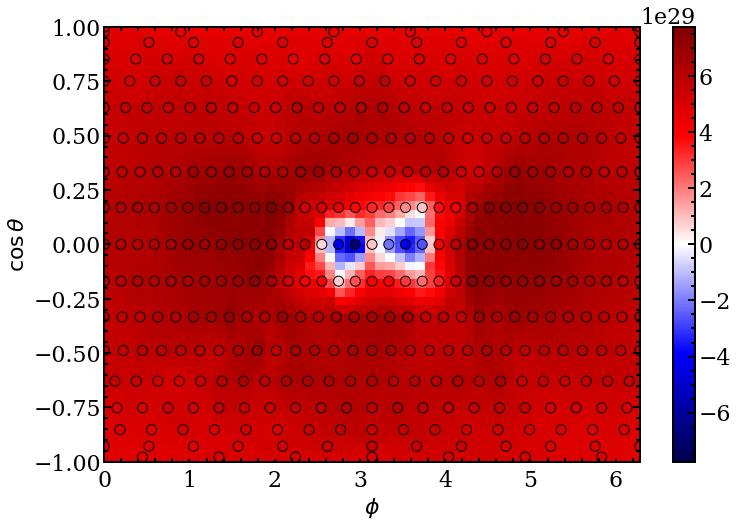

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


minzplotneg = 2.392208445178337e+27, maxzplotneg=4.915228477227235e+29
minzplotpos = 3.3216356061711744e+27, maxzplotpos=7.636814249299747e+29


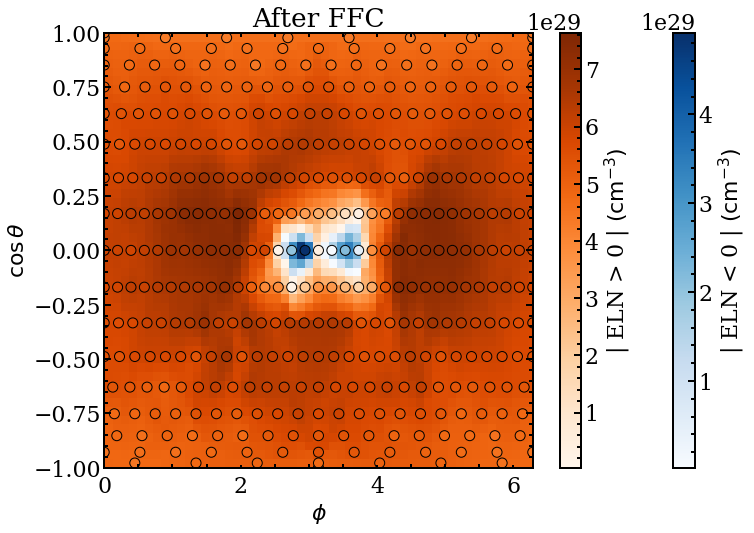

In [161]:
phi_fi, mu_fi, eln_xln_fi, phi_for_plot, mu_for_plot, eln_xln_for_plot = fac.do_interpolation(phi, theta, eln_xln)

print("max(eln_xln_fi):", np.max(eln_xln_fi))
print("min(eln_xln_fi):", np.min(eln_xln_fi))
maxabsval = np.max(np.abs(eln_xln_fi))

pf.plot_pcolormesh_with_contour_and_scatter_one_cbar(
    x1=phi_for_plot,
    y1=mu_for_plot,
    z1=eln_xln_for_plot,
    min_cb1=-maxabsval,
    max_cb1=+maxabsval,
    cbar_label1=r'',
    colormap1='seismic',
    x_label=r'$\phi$',
    y_label=r'$\cos\theta$',
    title=f'', 
    filename='plots/ee_flux_angular_dist.png',
    x_scatter1=phi_fi,
    y_scatter1=mu_fi,
    z_scatter1=eln_xln_fi
)

###########################################
# Compute quantities for plot in log scale
###########################################

xplot = phi_for_plot.copy()
yplot = mu_for_plot.copy()
zplot = eln_xln_for_plot.copy()

zplotneg = zplot.copy()
zplotpos = zplot.copy()

maskpos = zplot >= 0.0
maskneg = zplot <= 0.0

zplotneg = -1.0*zplotneg
zplotneg[~maskneg] = np.nan
minzplotneg = np.nanmin(zplotneg)
maxzplotneg = np.nanmax(zplotneg)
print(f'minzplotneg = {minzplotneg}, maxzplotneg={maxzplotneg}')

zplotpos = +1*zplotpos
zplotpos[~maskpos] = np.nan
minzplotpos = np.nanmin(zplotpos)
maxzplotpos = np.nanmax(zplotpos)
print(f'minzplotpos = {minzplotpos}, maxzplotpos={maxzplotpos}')

maskneg = eln_xln_fi < 0
elnneg = -1.0 * eln_xln_fi[maskneg]
muneg = mu_fi[maskneg]
phineg = phi_fi[maskneg]

maskpos = eln_xln_fi > 0
elnpos = eln_xln_fi[maskpos]
mupos = mu_fi[maskpos]
phipos = phi_fi[maskpos]

xscat1 = phineg
yscat1 = muneg
zscat1 = elnneg

xscat2 = phipos
yscat2 = mupos
zscat2 = elnpos

# r_point = np.array([Xc[cell_index_i, cell_index_j, cell_index_k], Yc[cell_index_i, cell_index_j, cell_index_k], Zc[cell_index_i, cell_index_j, cell_index_k]])

minzplotneg = 1.1961042225891685e+27
maxzplotneg=2.4576142386136176e+29
minzplotpos = 1.6608178030855872e+27
maxzplotpos=3.8184071246498735e+29

minzplotneg = None
maxzplotneg = None
minzplotpos = None
maxzplotpos = None

pf.plot_pcolormesh_with_contour_and_scatter(x1=xplot, 
                                            y1=yplot, 
                                            z1=zplotneg, 
                                            min_cb1=minzplotneg, 
                                            max_cb1=maxzplotneg, 
                                            cbar_label1=r'| ELN < 0 | $(\mathrm{{cm}}^{{-3}})$', 
                                            colormap1='Blues', 
                                            x2=xplot, 
                                            y2=yplot, 
                                            z2=zplotpos, 
                                            min_cb2=minzplotpos, 
                                            max_cb2=maxzplotpos, 
                                            cbar_label2=r'| ELN > 0 | $(\mathrm{{cm}}^{{-3}})$', 
                                            colormap2='Oranges', 
                                            x_label=r'$\phi$', 
                                            y_label=r'$\cos\theta$', 
                                            # title=f'Plotting particle values with no interpolation\n$r=({r_point[0]/1e5:.1f}, {r_point[1]/1e5:.1f}, {r_point[2]/1e5:.1f})\,\mathrm{{km}},\,t={time/1e-3:.2f}\,\mathrm{{ms}}$', 
                                            title=f'After FFC', 
                                            filename=f'plots/elnxln_combined_zx_.png',
                                            x_scatter1=xscat1,
                                            y_scatter1=yscat1,
                                            z_scatter1=zscat1,
                                            x_scatter2=xscat2,
                                            y_scatter2=yscat2,
                                            z_scatter2=zscat2,
                                            sc_point_color=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


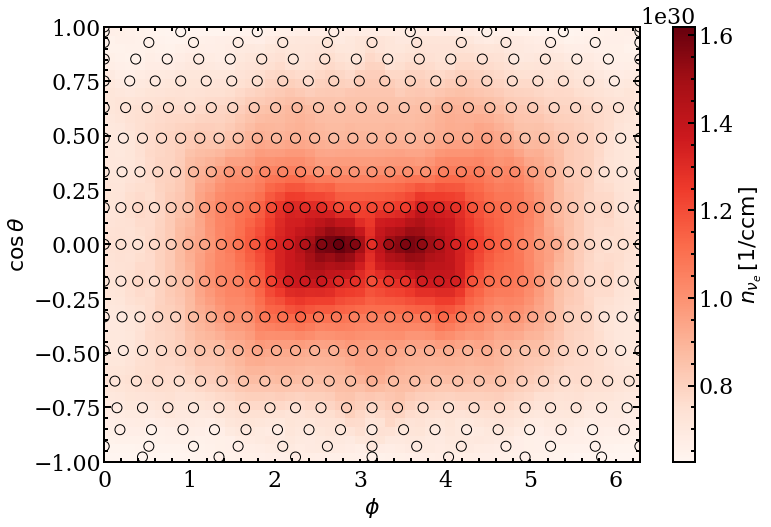

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


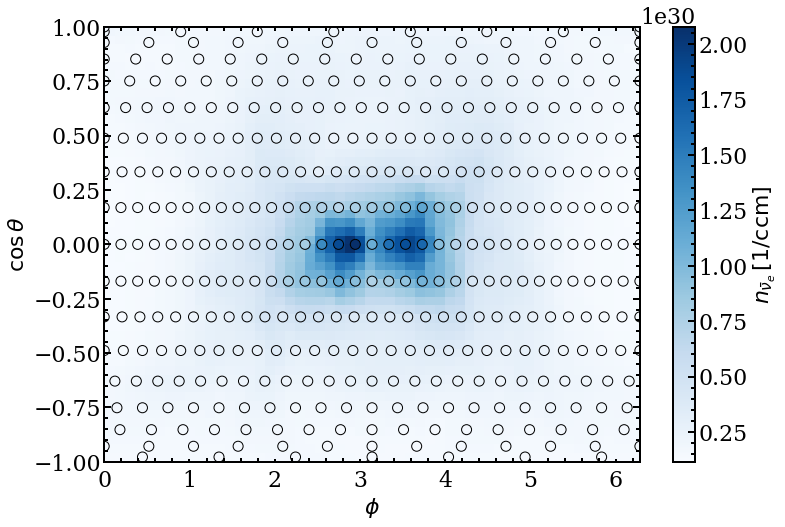

In [162]:
phi_fi, mu_fi, ee_xln_fi, phi_for_plot, mu_for_plot, ee_for_plot = fac.do_interpolation(phi, theta, ee_unique_fluxes_mag)

pf.plot_pcolormesh_with_contour_and_scatter_one_cbar(
    x1=phi_for_plot,
    y1=mu_for_plot,
    # z1=np.log10(ee_for_plot),
    z1=ee_for_plot,
    min_cb1=None,
    max_cb1=None,
    # cbar_label1=r'$\log(n_{\nu_e}\,\left[1/\mathrm{ccm}\right])$',
    cbar_label1=r'$n_{\nu_e}\,\left[1/\mathrm{ccm}\right]$',
    colormap1='Reds',
    x_label=r'$\phi$',
    y_label=r'$\cos\theta$',
    title=f'', 
    filename='plots/ee_flux_angular_dist.png',
    x_scatter1=phi_fi,
    y_scatter1=mu_fi,
    # z_scatter1=np.log10(ee_xln_fi)
    z_scatter1=ee_xln_fi
)

phi_fi, mu_fi, eebar_xln_fi, phi_for_plot, mu_for_plot, eebar_for_plot = fac.do_interpolation(phi, theta, eebar_unique_fluxes_mag)

pf.plot_pcolormesh_with_contour_and_scatter_one_cbar(
    x1=phi_for_plot,
    y1=mu_for_plot,
    # z1=np.log10(eebar_for_plot),
    z1=eebar_for_plot,
    min_cb1=None,
    max_cb1=None,
    # cbar_label1=r'$\log(n_{\bar{\nu}_e}\,\left[1/\mathrm{ccm}\right])$',
    cbar_label1=r'$n_{\bar{\nu}_e}\,\left[1/\mathrm{ccm}\right]$',
    colormap1='Blues',
    x_label=r'$\phi$',
    y_label=r'$\cos\theta$',
    title=f'', 
    filename='plots/eebar_flux_angular_dist.png',
    x_scatter1=phi_fi,
    y_scatter1=mu_fi,
    # z_scatter1=np.log10(eebar_xln_fi)
    z_scatter1=eebar_xln_fi
)

### Plotting ELN distribution per energy

/tmp/ipykernel_2202610/3836704836.py:54: RuntimeWarning: All-NaN slice encountered
  minzplotneg = np.nanmin(zplotneg)
/tmp/ipykernel_2202610/3836704836.py:55: RuntimeWarning: All-NaN slice encountered
  maxzplotneg = np.nanmax(zplotneg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing energy: 1 MeV
Number of particles with energy 1 MeV: 378
minzplotneg = nan, maxzplotneg=nan
minzplotpos = 1.130951658020062e+26, maxzplotpos=1.0837523471431928e+27


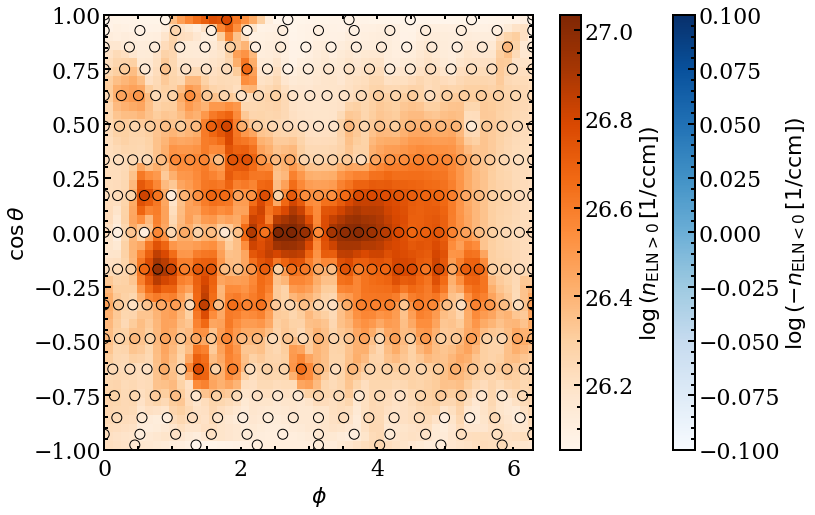

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


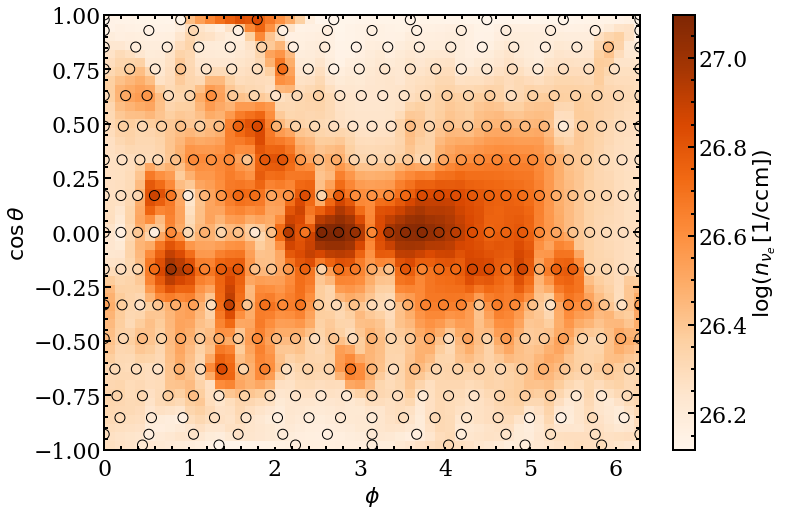

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


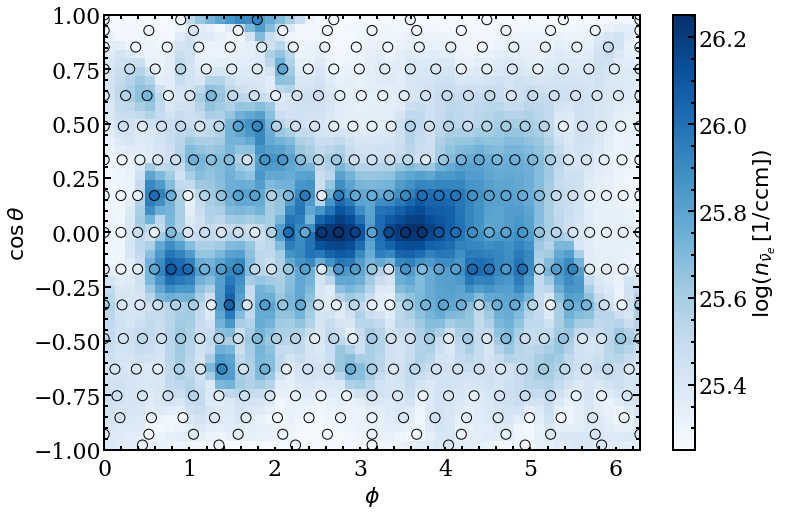

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing energy: 15.6909 MeV
Number of particles with energy 15.6909 MeV: 378
minzplotneg = 3.857985338563742e+26, maxzplotneg=1.653570995945055e+29
minzplotpos = 1.0210899558527881e+27, maxzplotpos=2.045601264290775e+29


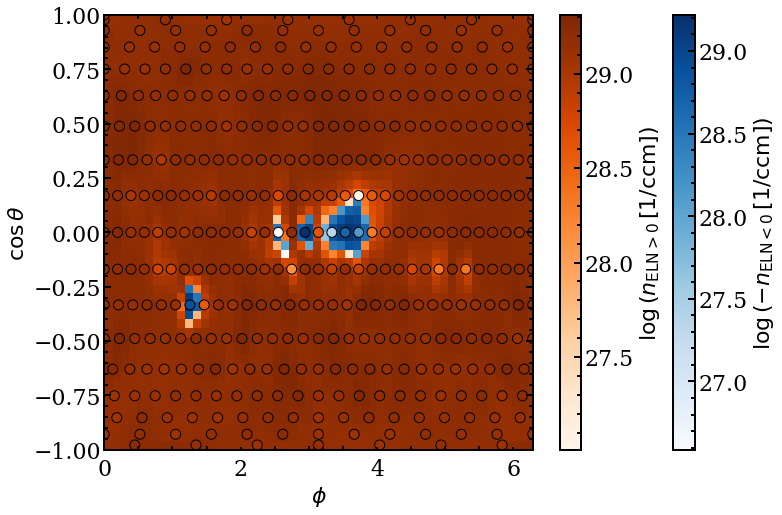

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


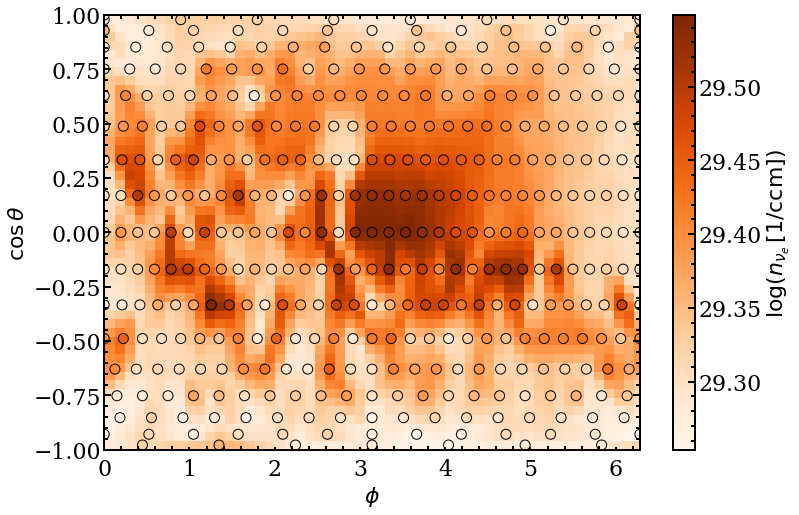

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


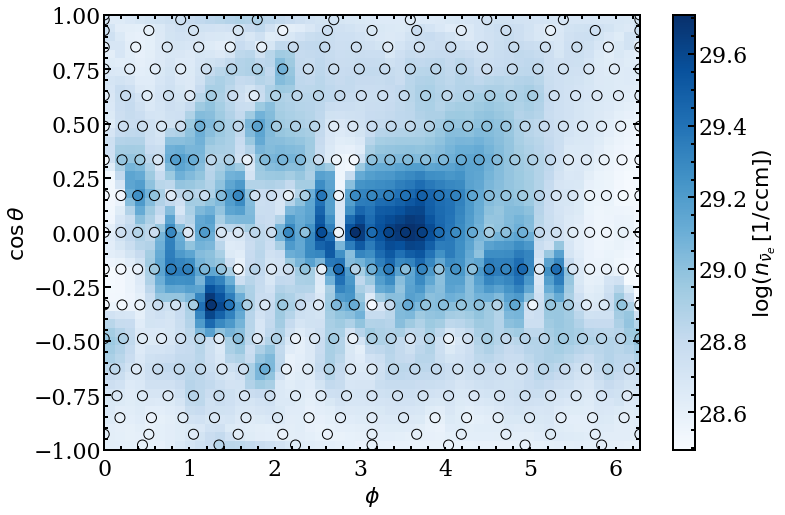

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing energy: 35.5357 MeV
Number of particles with energy 35.5357 MeV: 378
minzplotneg = 3.756232132614305e+24, maxzplotneg=9.94124600488334e+28
minzplotpos = 9.025401526897557e+24, maxzplotpos=7.631691280813153e+27


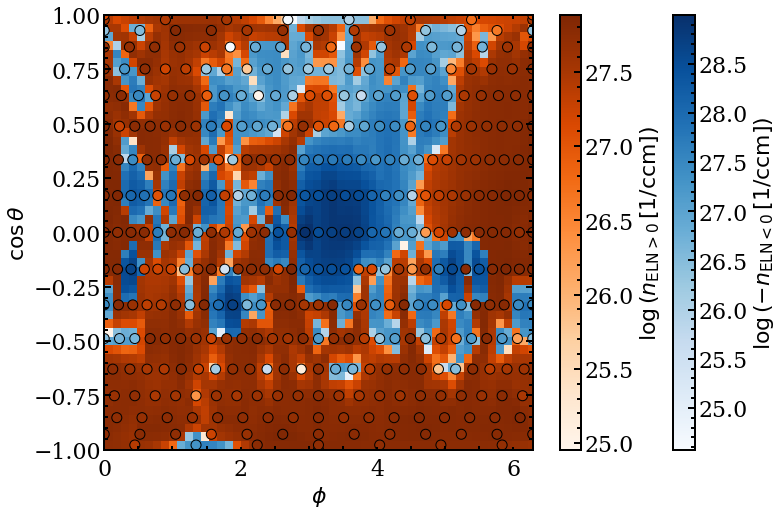

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


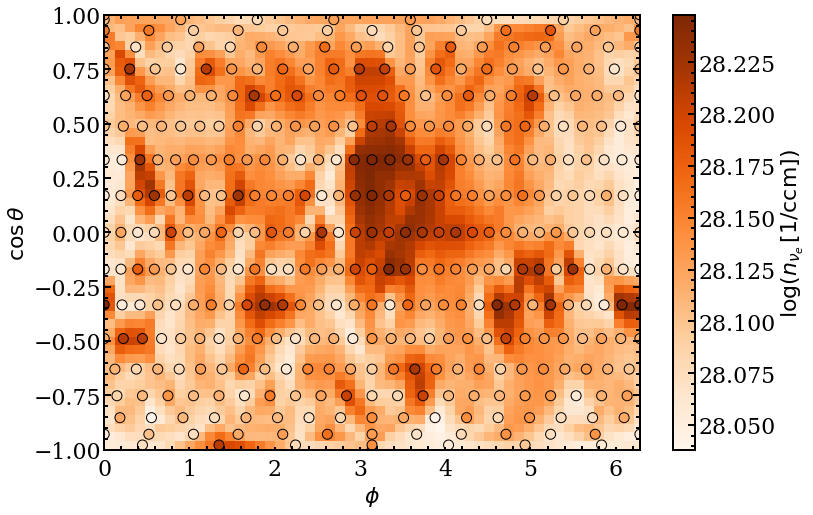

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


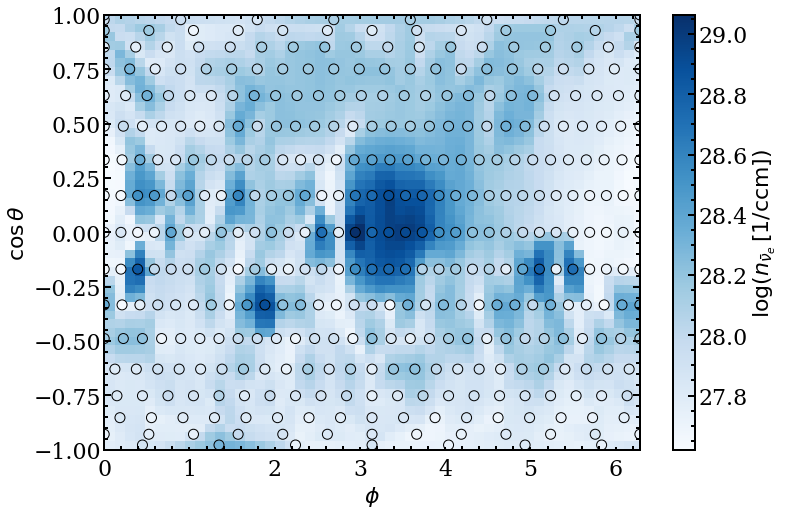

In [ ]:
# Particles energies
particles_energies_erg = particles_dict_this_cell['pupt'] # erg
particles_energies_MeV = particles_energies_erg / ( 1e6 * pc.CGSUnitsConst.eV ) # MeV

# energies_center_Mev = [1, 3, 5.23824, 8.00974, 11.4415, 15.6909, 20.9527, 27.4681, 35.5357, 45.5254, 57.8951, 73.2117, 92.1775] # Energy in Mev
# energies_center_Mev = [1, 15.6909, 35.5357] # Energy in Mev
energies_center_Mev = [1] # Energy in Mev

for E_cent_Mev in energies_center_Mev:

    print(f'Processing energy: {E_cent_Mev} MeV')

    # Create a mask for the energies (approximate match)
    mask_energy = np.isclose(particles_energies_MeV, E_cent_Mev, atol=0.1)

    print(f'Number of particles with energy {E_cent_Mev} MeV: {np.sum(mask_energy)}')

    fluxee_energy_masked = fluxee_all[mask_energy]
    fluxuu_energy_masked = fluxuu_all[mask_energy]
    fluxtt_energy_masked = fluxtt_all[mask_energy]
    fluxeebar_energy_masked = fluxeebar_all[mask_energy]
    fluxuubar_energy_masked = fluxuubar_all[mask_energy]
    fluxnttbar_energy_masked = fluxnttbar_all[mask_energy]

    ee_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxee_energy_masked, axis=1)
    uu_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxuu_energy_masked, axis=1)
    tt_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxtt_energy_masked, axis=1)
    eebar_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxeebar_energy_masked, axis=1)
    uubar_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxuubar_energy_masked, axis=1)
    ttbar_unique_fluxes_mag_energy_masked = np.linalg.norm(fluxnttbar_energy_masked, axis=1)

    eln_xln = (
        (ee_unique_fluxes_mag_energy_masked - eebar_unique_fluxes_mag_energy_masked ) -
        (uu_unique_fluxes_mag_energy_masked - uubar_unique_fluxes_mag_energy_masked ) -
        (tt_unique_fluxes_mag_energy_masked - ttbar_unique_fluxes_mag_energy_masked )
    )
    
    phi_fi, mu_fi, eln_xln_fi, phi_for_plot, mu_for_plot, eln_xln_for_plot = fac.do_interpolation(phi, theta, eln_xln)

    # Compute quantities for plot

    xplot = phi_for_plot.copy()
    yplot = mu_for_plot.copy()
    zplot = eln_xln_for_plot.copy()

    zplotneg = zplot.copy()
    zplotpos = zplot.copy()

    maskpos = zplot >= 0.0
    maskneg = zplot <= 0.0

    zplotneg = -1.0*zplotneg
    zplotneg[~maskneg] = np.nan
    minzplotneg = np.nanmin(zplotneg)
    maxzplotneg = np.nanmax(zplotneg)
    print(f'minzplotneg = {minzplotneg}, maxzplotneg={maxzplotneg}')

    zplotpos = +1*zplotpos
    zplotpos[~maskpos] = np.nan
    minzplotpos = np.nanmin(zplotpos)
    maxzplotpos = np.nanmax(zplotpos)
    print(f'minzplotpos = {minzplotpos}, maxzplotpos={maxzplotpos}')

    maskneg = eln_xln_fi < 0
    elnneg = -1.0 * eln_xln_fi[maskneg]
    muneg = mu_fi[maskneg]
    phineg = phi_fi[maskneg]

    maskpos = eln_xln_fi > 0
    elnpos = eln_xln_fi[maskpos]
    mupos = mu_fi[maskpos]
    phipos = phi_fi[maskpos]

    xscat1 = phineg
    yscat1 = muneg
    zscat1 = elnneg

    xscat2 = phipos
    yscat2 = mupos
    zscat2 = elnpos

    pf.plot_pcolormesh_with_contour_and_scatter(x1=xplot, 
                                            y1=yplot, 
                                            z1=np.log10(zplotneg), 
                                            # z1=zplotneg, 
                                            min_cb1=None, 
                                            max_cb1=None, 
                                            cbar_label1=r'$\log\left(-n_{\mathrm{ELN}<0}\,\left[1/\mathrm{ccm}\right]\right)$', 
                                            colormap1='Blues', 
                                            x2=xplot, 
                                            y2=yplot, 
                                            z2=np.log10(zplotpos), 
                                            # z2=zplotpos, 
                                            min_cb2=None, 
                                            max_cb2=None, 
                                            cbar_label2=r'$\log\left(n_{\mathrm{ELN}>0}\,\left[1/\mathrm{ccm}\right]\right)$', 
                                            colormap2='Oranges',
                                            x_label=r'$\phi$', 
                                            y_label=r'$\cos\theta$', 
                                            title=f'', 
                                            filename=f'plots/log_elnxln_combined_zx_{E_cent_Mev:.1f}_MeV.png',
                                            x_scatter1=xscat1,
                                            y_scatter1=yscat1,
                                            z_scatter1=np.log10(zscat1),
                                            # z_scatter1=zscat1,
                                            x_scatter2=xscat2,
                                            y_scatter2=yscat2,
                                            z_scatter2=np.log10(zscat2),
                                            # z_scatter2=zscat2,
                                            sc_point_color=None)
        
    phi_fi, mu_fi, ee_xln_fi, phi_for_plot, mu_for_plot, ee_for_plot = fac.do_interpolation(phi, theta, ee_unique_fluxes_mag_energy_masked)

    pf.plot_pcolormesh_with_contour_and_scatter_one_cbar(
        x1=phi_for_plot,
        y1=mu_for_plot,
        z1=np.log10(ee_for_plot),
        min_cb1=None,
        max_cb1=None,
        cbar_label1=r'$\log(n_{\nu_e}\,\left[1/\mathrm{ccm}\right])$',
        colormap1='Oranges',
        x_label=r'$\phi$',
        y_label=r'$\cos\theta$',
        title=f'', 
        filename=f'plots/ee_flux_angular_dist_{E_cent_Mev:.1f}_MeV.png',
        x_scatter1=phi_fi,
        y_scatter1=mu_fi,
        z_scatter1=np.log10(ee_xln_fi)
    )

    phi_fi, mu_fi, eebar_xln_fi, phi_for_plot, mu_for_plot, eebar_for_plot = fac.do_interpolation(phi, theta, eebar_unique_fluxes_mag_energy_masked)

    pf.plot_pcolormesh_with_contour_and_scatter_one_cbar(
        x1=phi_for_plot,
        y1=mu_for_plot,
        z1=np.log10(eebar_for_plot),
        min_cb1=None,
        max_cb1=None,
        cbar_label1=r'$\log(n_{\bar{\nu}_e}\,\left[1/\mathrm{ccm}\right])$',
        colormap1='Blues',
        x_label=r'$\phi$',
        y_label=r'$\cos\theta$',
        title=f'', 
        filename=f'plots/eebar_flux_angular_dist_{E_cent_Mev:.1f}_MeV.png',
        x_scatter1=phi_fi,
        y_scatter1=mu_fi,
        z_scatter1=np.log10(eebar_xln_fi)
    )